In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm


from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

from my_model import CustomModel, PT5_classification_model, train_per_protein, create_dataset

There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB
[2024-04-12 16:43:51,536] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# from my_model import save_model, load_model_

In [3]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

In [4]:
import os.path
#os.chdir("./")
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [5]:
def process_types(string, typ = 'A'):
    
    pattern = f'[A-Z]+?\d+'
    res = re.search(pattern, string)[0]
    return res#.replace(typ, '', 1)


def add_spaces(seq):
     return ' '.join(list(seq))



def generate_seqs(gene='j', chain='B', counts=1000):
    pref = 'OLGA/olga/'
    if chain == 'B':
        params_file_name = pref + 'default_models/human_T_beta/model_params.txt'
        marginals_file_name = pref + 'default_models/human_T_beta/model_marginals.txt'
        V_anchor_pos_file = pref + 'default_models/human_T_beta/V_gene_CDR3_anchors.csv'
        J_anchor_pos_file = pref + 'default_models/human_T_beta/J_gene_CDR3_anchors.csv'
        
        genomic_data = load_model.GenomicDataVDJ()
        genomic_data.load_igor_genomic_data(params_file_name, V_anchor_pos_file, J_anchor_pos_file)

        generative_model = load_model.GenerativeModelVDJ()
        generative_model.load_and_process_igor_model(marginals_file_name)
        
        seq_gen_model = seq_gen.SequenceGenerationVDJ(generative_model, genomic_data)
        
    elif chain == 'A':
        params_file_name = pref + 'default_models/human_T_alpha/model_params.txt'
        marginals_file_name = pref + 'default_models/human_T_alpha/model_marginals.txt'
        V_anchor_pos_file = pref + 'default_models/human_T_alpha/V_gene_CDR3_anchors.csv'
        J_anchor_pos_file = pref + 'default_models/human_T_alpha/J_gene_CDR3_anchors.csv'
        
        genomic_data = load_model.GenomicDataVJ()
        genomic_data.load_igor_genomic_data(params_file_name, V_anchor_pos_file, J_anchor_pos_file)

        generative_model = load_model.GenerativeModelVJ()
        generative_model.load_and_process_igor_model(marginals_file_name)
        
        seq_gen_model = seq_gen.SequenceGenerationVJ(generative_model, genomic_data)
        
    
    
    generated = {}
    
    if gene=='j':
        for _ in range(counts):
            res = seq_gen_model.gen_rnd_prod_CDR3()#[1::2]

            if f'TR{chain}J{str(res[-1])}' not in generated.keys():
                generated[f'TR{chain}J{str(res[-1])}'] = [res[1]]
            else:
                generated[f'TR{chain}J{str(res[-1])}'].append(res[1])
                
    elif gene == 'v':
        for _ in range(counts):
            res = seq_gen_model.gen_rnd_prod_CDR3()
            
            if f'TR{chain}V{str(res[-1])}' not in generated.keys():
                generated[f'TR{chain}V{str(res[-1])}'] = [res[1]]
            else:
                generated[f'TR{chain}V{str(res[-1])}'].append(res[1])
                
    else:
        raise ValueError('Wrong gene type')
        
    return generated
    
    
def balance_majority(genes: pd.DataFrame, colu, min_count=30, max_count=1500):
    counts = genes[colu].value_counts()
    counts = counts.drop(counts[min_count>counts].index)
    resampled = pd.DataFrame()
    maj_clss = (counts[counts>max_count]).index
    left_genes = pd.DataFrame()
    mean_clss = counts[(counts<max_count) & (min_count<counts)].index#[i for i in genes[colu] if i not in min_classes]
    for cl in mean_clss:
        left_genes = pd.concat([left_genes, genes[genes[colu]==cl]])

    for maj_cl in maj_clss:
        #print(maj_cl)
        
        resampled = pd.concat([resampled, resample(genes[genes[colu] == maj_cl], replace=False, n_samples=max_count, random_state=42)])
    return pd.concat([left_genes, resampled])

# Prepare data

In [6]:
beta_data = pd.read_csv('data/selected_cdr_beta_440001980101_S87_L001.csv', index_col=0)

In [7]:
beta_data

,cdr3aa,v,d,j
0,CASSPWTGTEQFF,TRBV14,TRBD1,TRBJ2-1
1,CASSPRERRVEQFF,TRBV10-1,TRBD1,TRBJ2-1
2,CASSYGGTDTQYF,TRBV6-6,.,TRBJ2-3
5,CASSPGHLSSGSYGYTF,TRBV18,TRBD1,TRBJ1-2
6,CASRTGGGNTDTQYF,TRBV4-1,TRBD1,TRBJ2-3
...,...,...,...,...
42806,CASSLRPQHF,TRBV6-6,.,TRBJ1-5
42807,CASSDVGYTF,TRBV25-1,.,TRBJ1-2
42808,CASRGVGYTF,TRBV2,TRBD1,TRBJ1-2
42809,CSASFVTQYF,TRBV20-1,.,TRBJ2-5


<BarContainer object of 3 artists>

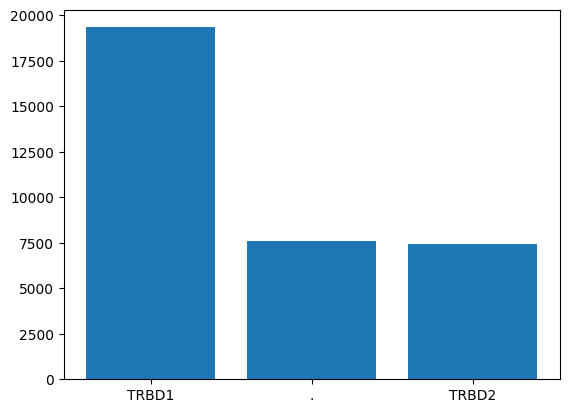

In [8]:
plt.bar(beta_data.d.unique(), beta_data.d.value_counts())

In [9]:
d_genes = beta_data[['cdr3aa', 'd']]
d_genes = d_genes.drop(index=d_genes[d_genes['d'] == '.'].index)


In [10]:
d_test_dataset = d_genes.sample(frac=0.2, random_state=42)
d_genes = d_genes.drop(d_test_dataset.index)

In [11]:
d_genes['cdr3aa'] = d_genes['cdr3aa'].map(add_spaces)
d_test_dataset['cdr3aa'] = d_test_dataset['cdr3aa'].apply(add_spaces)

In [12]:
# d_resampled.d.value_counts()

In [13]:
d_resampled = balance_majority(d_genes, 'd', max_count=8000)

<BarContainer object of 2 artists>

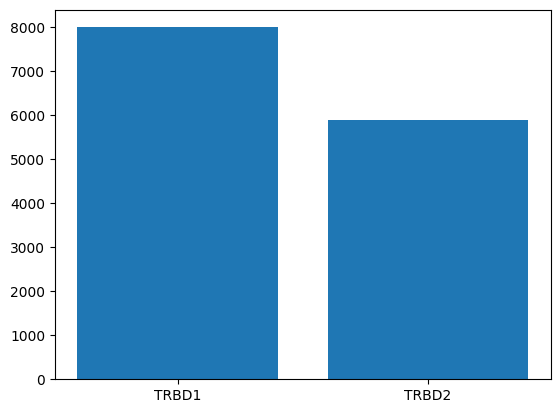

In [14]:
plt.bar(d_resampled.d.value_counts().index, d_resampled.d.value_counts())

In [15]:
l_enc = LabelEncoder()
l_enc.fit(d_resampled['d'])
d_resampled['d'] = l_enc.transform(d_resampled['d'])
d_test_dataset['d'] = l_enc.transform(d_test_dataset['d'])

In [16]:
mapping = dict(zip(l_enc.classes_, range(len(l_enc.classes_))))
mapping

{'TRBD1': 0, 'TRBD2': 1}

In [17]:
d_ans = d_test_dataset['d']
d_test_dataset = d_test_dataset.drop(columns=['d'])

In [18]:
d_test_dataset

,cdr3aa
24871,C A S S A E D R G S G N T I Y F
31293,C S A G V L D T Q Y F
23786,C S A A N R E N T E A F F
32833,C S A P N P G Q G V L E Q F F
4354,C A S S Y R G G G Q E T Q Y F
...,...
7742,C A S S A R R G L G A F F
25187,C A S S P V T A P G S G N T I Y F
8024,C A S S W R G G T N E Q F F
38164,C A S S I E T G G S S Y N E Q F F


# Train the model

## Prottrans

In [19]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(d_resampled, test_size=0.2, random_state=42)

In [20]:
train_df = train_df.rename({'cdr3aa': 'sequence', 'd': 'label'}, axis=1)
val_df = val_df.rename({'cdr3aa': 'sequence', 'd': 'label'}, axis=1)
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
val_df["sequence"]=val_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)

In [21]:
N_LABELS = d_resampled.d.nunique()
tokenizer, model, history = train_per_protein(train_df, val_df, num_labels=N_LABELS, batch=8, accum=8, epochs=4, seed=42)

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.10.layer.1.EncDecAttention.v.weight', 'decoder.block.17.layer.1.EncDecAttention.o.weight', 'decoder.block.2.layer.2.DenseReluDense.wo.weight', 'decoder.block.15.layer.0.layer_norm.weight', 'decoder.block.21.layer.1.EncDecAttention.o.weight', 'decoder.block.23.layer.1.EncDecAttention.v.weight', 'decoder.block.8.layer.1.layer_norm.weight', 'decoder.block.5.layer.1.EncDecAttention.v.weight', 'decoder.block.4.layer.2.DenseReluDense.wi.weight', 'decoder.block.4.layer.0.SelfAttention.k.weight', 'decoder.block.21.layer.0.SelfAttention.q.weight', 'decoder.block.18.layer.2.DenseReluDense.wi.weight', 'decoder.block.22.layer.0.SelfAttention.v.weight', 'decoder.block.20.layer.2.DenseReluDense.wo.weight', 'decoder.block.17.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.1.layer_norm.weight', 'decoder.block.7.layer.1.

ProtT5_Classfier
Trainable Parameter: 1209194499
ProtT5_LoRA_Classfier
Trainable Parameter: 3560451

[2024-04-11 17:10:02,679] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-04-11 17:10:02,680] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[2024-04-11 17:10:02,691] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.14.0, git-hash=unknown, git-branch=unknown
[2024-04-11 17:10:05,539] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False


Using /home/akabalina/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/akabalina/.cache/torch_extensions/py39_cu117/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cpu_adam...


ninja: no work to do.
Time to load cpu_adam op: 3.1624507904052734 seconds
[2024-04-11 17:10:11,339] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer
[2024-04-11 17:10:11,340] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-04-11 17:10:11,401] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-04-11 17:10:11,402] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-04-11 17:10:11,403] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float32 ZeRO stage 2 optimizer
[2024-04-11 17:10:11,404] [INFO] [stage_1_and_2.py:149:__init__] Reduce bucket size 200000000
[2024-04-11 17:10:11,405] [INFO] [stage_1_and_2.py:150:__init__] Allgather bucket size 200000000
[2024-04-11 17:10:11,405] [INFO] [stage_1_and_2.py:151:__ini

***** Running training *****
  Num examples = 15946
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 8
  Total optimization steps = 996
  Number of trainable parameters = 3560451


Adam Optimizer #0 is created with AVX512 arithmetic capability.
Config: alpha=0.000300, betas=(0.900000, 0.999000), weight_decay=0.000000, adam_w=1


Epoch,Training Loss,Validation Loss,Accuracy
0,0.893100,0.802312,0.650865
1,0.762700,0.733462,0.678957
2,0.708700,0.708395,0.690996
3,0.684100,0.697969,0.702784


***** Running Evaluation *****
  Num examples = 3987
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3987
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3987
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3987
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




In [22]:
my_test=d_test_dataset.rename({'cdr3aa': 'sequence'}, axis=1)
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)

my_test.head(5)

,sequence
40187,C A S S L A L R A L P Y F
20895,C A S S L I G S G G Y Q E T Q Y F
5376,C A S T P S G G S T D T Q Y F
18581,C A S S L Q V A G N S P L H F
12937,C A S R S S W G S Y N E Q F F


In [23]:
# test_set=create_dataset(tokenizer_, list(my_test['sequence']),list(d_ans))
test_set=create_dataset(tokenizer, list(my_test['sequence']),list(d_ans))

test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)

# Put the model in evaluation mode
# model_reload.eval()
model.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # predictions += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        predictions += model(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 859/859 [01:00<00:00, 14.11it/s]


In [24]:
predictions= [item.argmax() for item in np.array(predictions)]
print("F1 score: ", f1_score(list(d_ans), predictions, average='macro'))

F1 score:  0.6797812864933279


## TCR-bert

In [19]:
my_model_ = CustomModel(n_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
input_ids, attention_masks, labels = my_model_.tokenize(d_resampled.cdr3aa, np.array(d_resampled['d']))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
train_dataset, val_dataset = my_model_.split_data(input_ids, attention_masks, labels)

11,122 training samples
2,781 validation samples


In [22]:
my_model_.fit(train_dataset, val_dataset, epochs=4)


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.51
  Training epcoh took: 0:00:33

Running Validation...
  Accuracy: 0.77
  Validation Loss: 0.47
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.43
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.43
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.36
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.48
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.30
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.49
  Validation took: 0:00:02

Training complete!


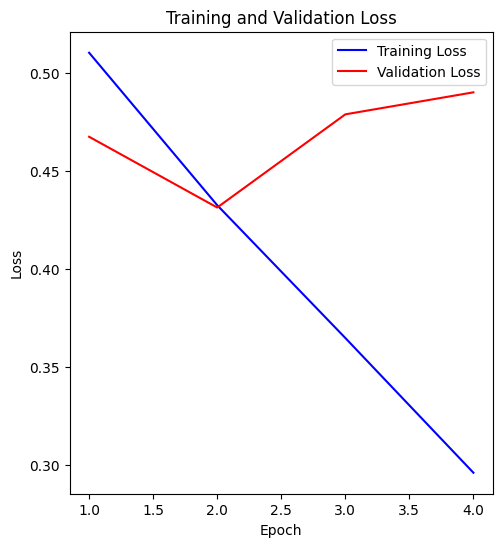

In [23]:
my_model_.draw_stats_plot()

In [30]:
save_model(my_model_,"./TCR_bert_d_genes_finetuned.pth")

N_LABELS = d_resampled['d'].nunique()
my_model_reload = load_model_("./TCR_bert_d_genes_finetuned.pth", mod_type='TCR-bert', num_labels=N_LABELS)

NameError: name 'save_model' is not defined

In [ ]:
my_model_reload.maximun_len = 25

In [24]:
# my_model_reload.to(device)
d_pred_labels = my_model_.predict(d_test_dataset['cdr3aa'])
f1_sc_d = f1_score(d_ans, d_pred_labels, average='macro')
print('Total f1_score: %.5f' % f1_sc_d)

Total f1_score: 0.77219


# Visualisation

In [25]:
import umap
import umap.plot
import matplotlib.pyplot as plt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
model_tcr = my_model_#reload

hid_sts = []
# hid_sts_med = []
lbls = []
model_tcr.to(device)

for seq in tqdm(d_genes.index):
    seq, lab = d_genes.loc[seq]
    en_dict = model_tcr.tokenizer.encode_plus(seq, add_special_tokens = True, 
                                      max_length = 25, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
    input_ids_test, att_mask_test = en_dict['input_ids'], en_dict['attention_mask']
    #my_model.model.eval()

    input_ids_test = input_ids_test.to(device)
    att_mask_test= att_mask_test.to(device)
    #lab = torch.tensor(lab).to(device)

    with torch.no_grad():
        outputs = model_tcr.model(input_ids_test, att_mask_test, output_hidden_states=True)
        
    hid_sts.append([torch.mean(tensor).item() for tensor in outputs.hidden_states])
    #hid_sts_med.append([torch.median(tensor).item() for tensor in outputs.hidden_states])
    lbls.append(lab)

  0%|          | 0/21411 [00:00<?, ?it/s]/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 21411/21411 [03:46<00:00, 94.54it/s]


<AxesSubplot: >

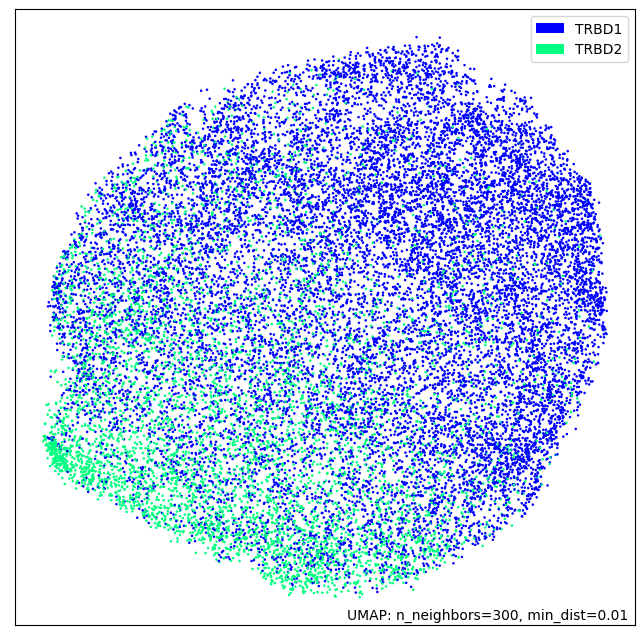

In [45]:
reduced = umap.UMAP(n_neighbors=300, min_dist=0.01).fit(hid_sts)

umap.plot.points(reduced, labels=np.array(lbls), color_key_cmap='winter')

In [53]:
# # emb = umap.UMAP(n_components=3).fit_transform(hid_sts)
# # emb = emb.T

# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")
 
# # Creating plot
# ax.scatter3D(emb[0], emb[1], emb[2], c=np.where(np.array(lbls)=='TRBD1', 'r', 'b'))
 
# # show plot
# plt.show()